In [1]:
import sys
import pathlib
import os
from skmap.catalog import DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data, calc_metrics
import joblib

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'
version = '20250404'

# Prepare

In [2]:
# model
model = joblib.load(f'{folder_path}/data/010_model_fine.tuned.joblib')
model.n_jobs=90

# covariates
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
# covs = read_features('/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/benchmark_selected.covs_ocd.txt')
print(f'{len(covs)} covariates')

# data
train = pd.read_parquet(f'{folder_path}/data/006_data_train_v{version}.pq')
test = pd.read_parquet(f'{folder_path}/data/004_data_test_v{version}.pq')

# set up
cv = GroupKFold(n_splits=5) 
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

train[tgt] = np.log1p(train[prop])
test[tgt] = np.log1p(test[prop])

67 covariates


# Train the model

In [3]:
ttprint('fit model on whole training data')
model.fit(train[covs], train[tgt])
ttprint('start prediction')


[15:46:45] fit model on whole training data
[15:46:50] start prediction


# Predict and calculate metrics

In [4]:
y_val = model.predict(test[covs])
test['ocd_pred'] = y_val

test.to_parquet(f'{folder_path}/data/011_data_test.pred_v{version}.pq')

In [5]:
# # load prediction
# data = pd.read_parquet(f'{folder_path}/data/011_data_test.pred.pq')
# y_val = np.array(data['ocd_pred'].values.tolist())

rsl = []
# calculate metrics
# mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(test[tgt], y_val, weights=None, space=space)
mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(test[prop], np.expm1(y_val), weights=None, space='normal')

rsl.append({
    'method': 'individual validation data',
    'MAE': mae_val,
    'MAPE': mape_val,
    'MedAE': medae_val,
    'R2': r2_val,
    'CCC': ccc_val,
    'bias': bias_val
    # 'cv_time (s)': cv_time
})
rsl = pd.DataFrame(rsl)
rsl

,method,MAE,MAPE,MedAE,R2,CCC,bias
0,individual validation data,7.998243,inf,4.262819,0.474955,0.636797,-3.069737


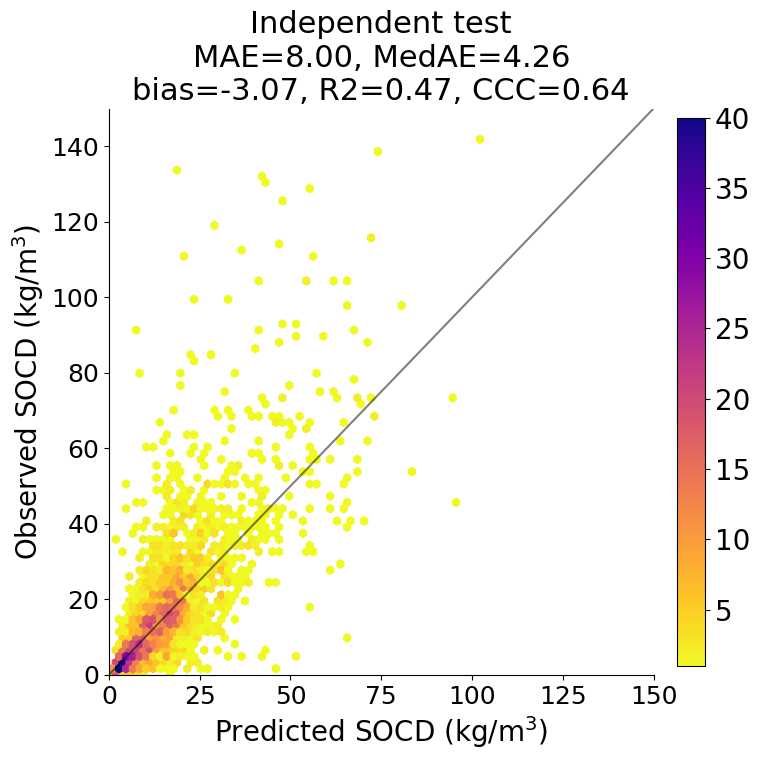

In [6]:
import matplotlib.pyplot as plt
import numpy as np

show_low = 0
show_high = 150

x_min, x_max = 0, 150
y_min, y_max = 0, 150

# Update rcParams for global font size settings
plt.rcParams.update({'font.size': 20})

# Create a single figure
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size for a single plot

# Plot the accuracy plot
ax.set_title(f'Independent test\nMAE={mae_val:.2f}, MedAE={medae_val:.2f}\nbias={bias_val:.2f}, R2={r2_val:.2f}, CCC={ccc_val:.2f}', fontsize=22) #, MAPE={mape_val:.2f}
hb = ax.hexbin(np.expm1(y_val), test[prop], gridsize=80, extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', mincnt=1, vmax=40)  # Adjust parameters as needed
ax.set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
ax.set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=20)
ax.set_aspect('auto', adjustable='box')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)
ax.tick_params(labelsize=18)
ax.set_xlim([show_low, show_high])
ax.set_ylim([show_low, show_high])

cbar = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
# plt.savefig(f'{folder_path}/figure/plot_accuracy_test.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


# Evaluate by strata

## Caculate metrics by strata

In [7]:
test = pd.read_parquet(f'{folder_path}/data/011_data_test.pred_v{version}.pq')

In [8]:
bins = [0, 20, 50, 100, 200]
labels = ['0-20', '20-50', '50-100', '100-200']
test['hzn_dep_bins'] = pd.cut(test['hzn_dep'], bins=bins, labels=labels, right=False)

# Initialize results list
stratified_results = []

# Part 1: Combined strata for `lc_survey` and `zhn_dep_bins`
for lc in test['lc_survey'].unique():
    for z_bin in test['hzn_dep_bins'].unique():
        # Filter for the combined strata
        subset = test[(test['lc_survey'] == lc) & (test['hzn_dep_bins'] == z_bin)]
        
        if len(subset) == 0:
            continue  # Skip if the subset is empty
        
        # Predict and calculate metrics for the subset
        # y_val_strata = model.predict(subset[covs])
        y_val_strata = subset['ocd_pred']
        mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(subset[prop], np.expm1(y_val_strata), weights=None, space='normal')
        
        # Append combined strata results
        stratified_results.append({
            'stratum_type': 'lc_survey + hzn_dep_bins',
            'lc_survey': lc,
            'hzn_dep_bin': z_bin,
            'MAE': mae_val,
            # 'MAPE': mape_val,
            'MedAE': medae_val,
            'R2': np.nan if len(subset)<5 else r2_val,
            'CCC': np.nan if len(subset)<5 else ccc_val,
            'bias': bias_val,
            'count': len(subset)  # Include sample size for context
        })

# Part 2: Independent strata for `time`
for time in test['time'].unique():
    # Filter for the independent stratum
    subset = test[test['time'] == time]
    
    if len(subset) == 0:
        continue  # Skip if the subset is empty
    
    # Predict and calculate metrics for the subset
    y_val_strata = model.predict(subset[covs])
    mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(subset[prop], np.expm1(y_val_strata), weights=None, space='normal')
    
    # Append independent stratum results
    stratified_results.append({
        'stratum_type': 'time',
        'time': time,
        'MAE': mae_val,
        # 'MAPE': mape_val,
        'MedAE': medae_val,
        'R2': np.nan if len(subset)<3 else r2_val,
        'CCC': np.nan if len(subset)<3 else ccc_val,
        'bias': bias_val,
        'test count': len(subset),
        'train count': len(train.loc[train['time']==time]) # Include sample size for context
    })

# Convert results to a DataFrame
stratified_results_df = pd.DataFrame(stratified_results)

/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [9]:
stratified_results_df

,stratum_type,lc_survey,hzn_dep_bin,MAE,MedAE,R2,CCC,bias,count,time,test count,train count
0,lc_survey + hzn_dep_bins,grassland,50-100,4.879119,1.433384,0.522641,0.734029,-1.253937,84.0,NaN,NaN,NaN
1,lc_survey + hzn_dep_bins,grassland,20-50,10.240691,5.131180,0.499145,0.656279,-1.970549,105.0,NaN,NaN,NaN
2,lc_survey + hzn_dep_bins,grassland,0-20,12.155311,8.007005,0.373787,0.572628,-6.249458,406.0,NaN,NaN,NaN
3,lc_survey + hzn_dep_bins,grassland,100-200,13.758181,6.240092,-0.129007,0.330758,2.683776,7.0,NaN,NaN,NaN
4,lc_survey + hzn_dep_bins,cropland,50-100,3.399623,1.126521,0.252034,0.300920,-2.087543,233.0,NaN,NaN,NaN
5,lc_survey + hzn_dep_bins,cropland,20-50,4.002957,2.854118,0.577964,0.709745,-0.975675,257.0,NaN,NaN,NaN
6,lc_survey + hzn_dep_bins,cropland,0-20,6.221982,3.829966,0.361919,0.539006,-2.122392,647.0,NaN,NaN,NaN
7,lc_survey + hzn_dep_bins,cropland,100-200,6.679132,7.443432,0.298896,0.476652,-2.918106,5.0,NaN,NaN,NaN
8,lc_survey + hzn_dep_bins,woodland,50-100,0.988176,0.988176,NaN,NaN,0.988176,2.0,NaN,NaN,NaN
9,lc_survey + hzn_dep_bins,woodland,20-50,4.665777,2.085698,0.757648,0.847168,-0.158287,17.0,NaN,NaN,NaN


In [10]:
stratified_results_df.to_csv(f'{folder_path}/metrics/metrics_test.evaluation.strata_v{version}.csv',index=False)

## Plot metrics by lc and depth

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for rows with non-NaN `lc_survey`
lc_dep_df = stratified_results_df.loc[stratified_results_df['lc_survey'].notna()]
lc_dep_df.loc[lc_dep_df['lc_survey'] == 'bare land & lichens/moss', 'lc_survey'] = 'bare land &\nlichens/moss'
lc_dep_df.loc[lc_dep_df['lc_survey'] == 'water areas & wetland', 'lc_survey'] = 'water areas\n& wetland'

# Define the correct order for soil depth bins
soil_depth_order = ['0-20', '20-50', '50-100', '100-200']

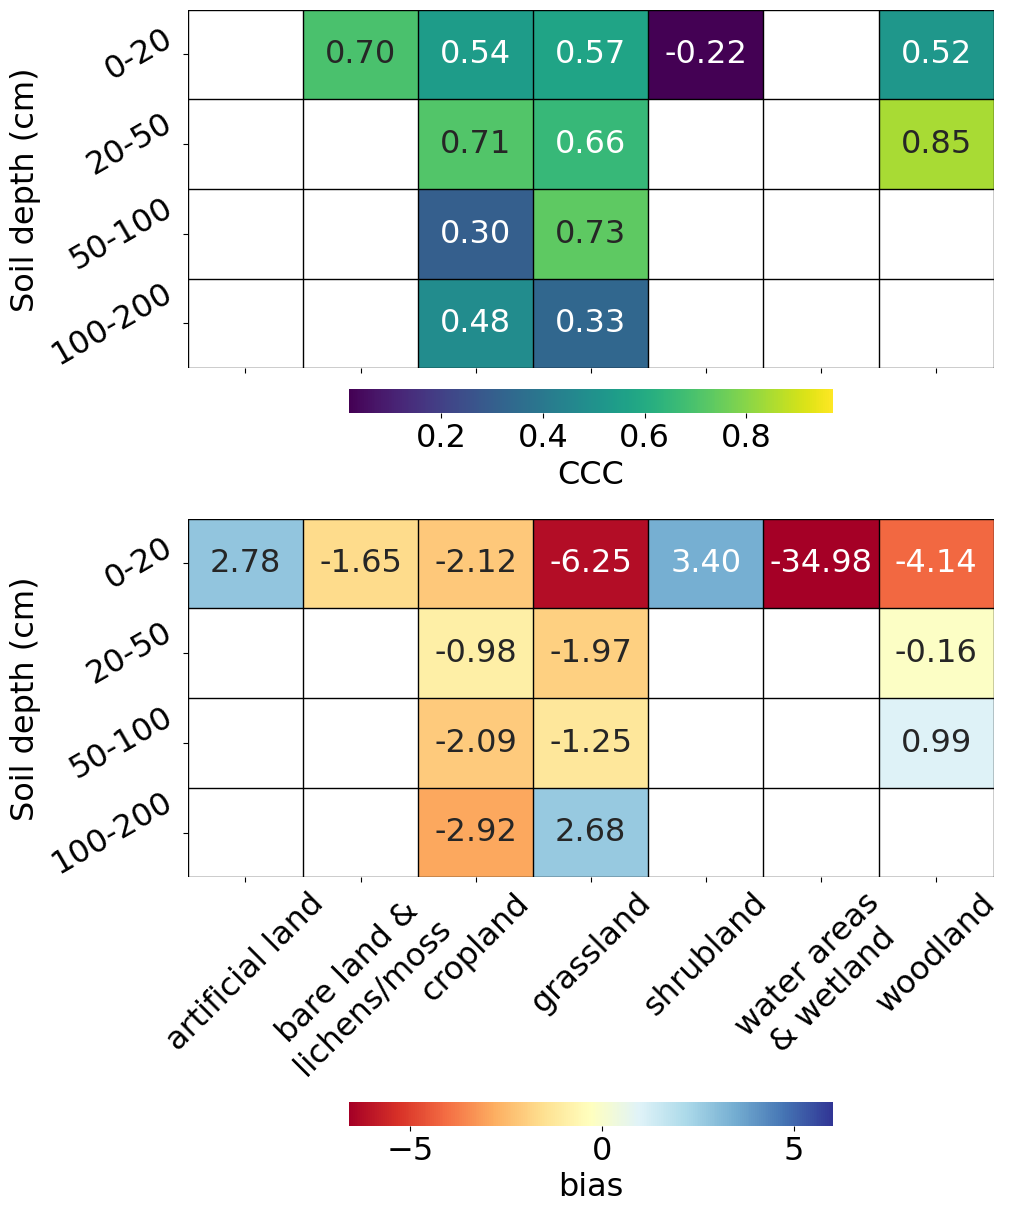

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12), constrained_layout=True, sharey=True, gridspec_kw={'hspace': 0.05})  # Share x-axis

# Define the metrics and colormaps
metrics = ['CCC', 'bias']
colormaps = ['viridis', 'RdYlBu']
vmmax = [0.02, -6]
vmmin = [0.97, 6]

# Loop through each metric to plot
for idx, metric in enumerate(metrics):
    # Pivot data for heatmap with axes switched: now soil depth on Y, LC on X
    pivot_data = lc_dep_df.pivot(index='hzn_dep_bin', columns='lc_survey', values=metric)
    pivot_data = pivot_data.reindex(soil_depth_order, axis=0)  # Reorder soil depth on Y-axis
    
    # Plot heatmap
    ax = sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".2f",
        cmap=colormaps[idx],
        cbar=True,
        cbar_kws={
            'orientation': 'horizontal',  # Position the colorbar on top
            'shrink': 0.6,
            'label': metric
        },
        annot_kws={"fontsize": 23},
        ax=axes[idx],
        vmin=vmmin[idx],
        vmax=vmmax[idx]
    )
    
    # Grid lines
    for i in range(pivot_data.shape[0]+1):  # Horizontal lines
        ax.axhline(i, color='black', linewidth=1)
    for j in range(pivot_data.shape[1]+1):  # Vertical lines
        ax.axvline(j, color='black', linewidth=1)
        
    # Titles and labels
    ax.set_ylabel('Soil depth (cm)', fontsize=23)
    ax.set_xlabel('', fontsize=23)
    
    # Tick formatting
    if idx==0:
        ax.set_xticklabels([], fontsize=23, rotation=40)
    else:
        ax.set_xticklabels(pivot_data.columns, fontsize=23, rotation=45)
    ax.set_yticklabels(pivot_data.index, fontsize=23, rotation=30)
    
    ax.collections[0].colorbar.ax.tick_params(labelsize=23)
    ax.collections[0].colorbar.set_label(metric, size=23)

plt.savefig(f'{folder_path}/figure/figure_metrics.pred_lc.depth_v{version}.pdf', bbox_inches='tight')
plt.show()

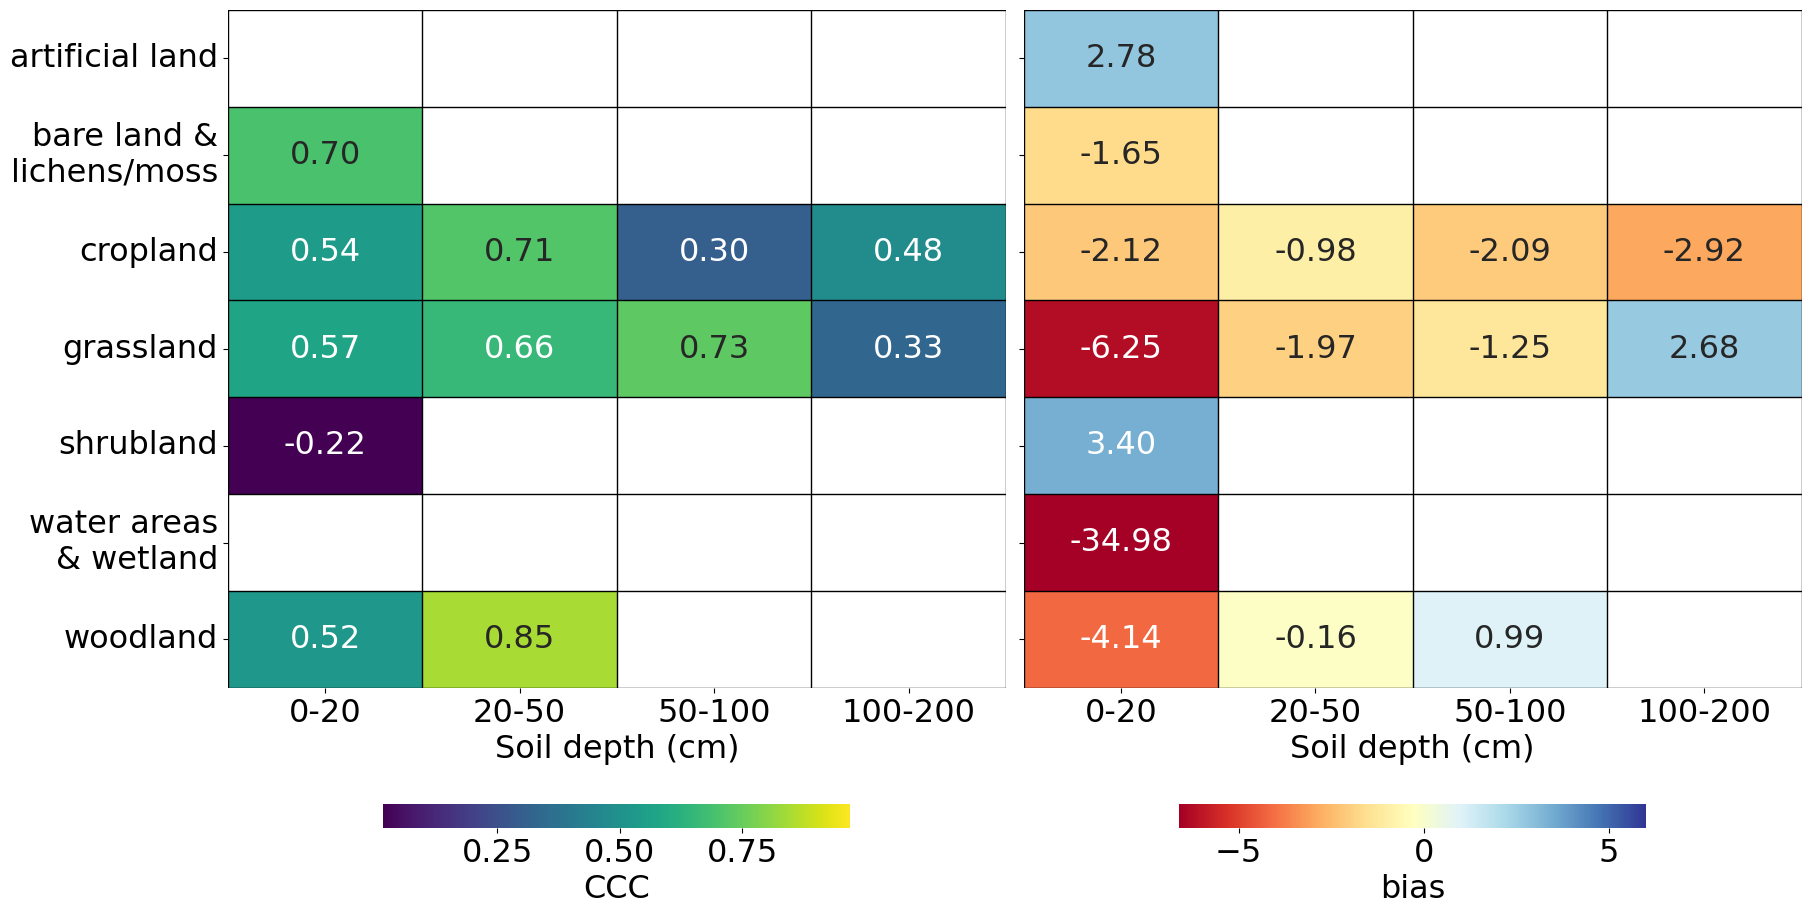

In [13]:
# Create a figure with subplots for both metrics, sharing the x-axis
fig, axes = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True, sharey=True)  # Share x-axis

# Define the metrics and colormaps
metrics = ['CCC', 'bias']
colormaps = ['viridis', 'RdYlBu']
vmmax = [0.02, -6]
vmmin = [0.97, 6]

# Loop through each metric to plot
for idx, metric in enumerate(metrics):
    # Pivot data for heatmap with axes switched
    pivot_data = lc_dep_df.pivot(index='lc_survey', columns='hzn_dep_bin', values=metric)
    pivot_data = pivot_data.reindex(soil_depth_order, axis=1)  # Ensure consistent order of soil depth bins
    
    # Plot heatmap
    ax = sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".2f",
        cmap=colormaps[idx],
        cbar=True,
        cbar_kws={
            'orientation': 'horizontal',  # Position the colorbar on top
            'shrink': 0.6,  # Shrink to make it more compact
            'label': metric
        },
        annot_kws={"fontsize": 23},  # Smaller font size for annotations
        ax=axes[idx],
        vmin = vmmin[idx],
        vmax = vmmax[idx]
    )
    # Add explicit grid lines
    for i in range(pivot_data.shape[0]+1):  # Horizontal grid lines
        ax.axhline(i, color='black', linewidth=1)
    for j in range(pivot_data.shape[1]+1):  # Vertical grid lines
        ax.axvline(j, color='black', linewidth=1)
        
    # Titles and labels
    ax.set_ylabel('', fontsize=23)
    ax.set_xlabel('Soil depth (cm)', fontsize=23)
    
    # Update tick management for swapped axes
    ax.tick_params(axis='y', labelsize=23, rotation=0)  # Rotate y-axis labels for clarity, rotation=40
    ax.set_xticklabels(pivot_data.columns, fontsize=23)
    
    ax.collections[0].colorbar.ax.tick_params(labelsize=23)
    ax.collections[0].colorbar.set_label(metric, size=23)

# Adjust layout for the entire figure
plt.show()


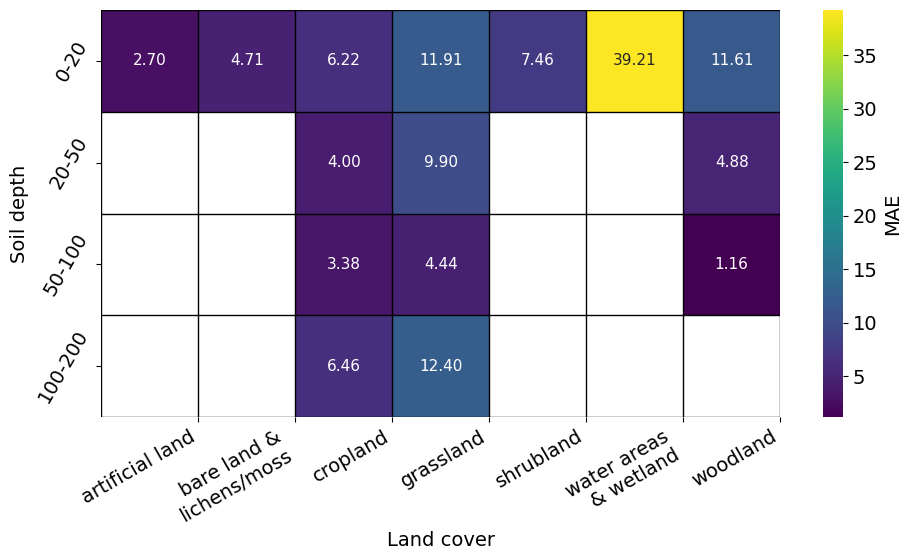

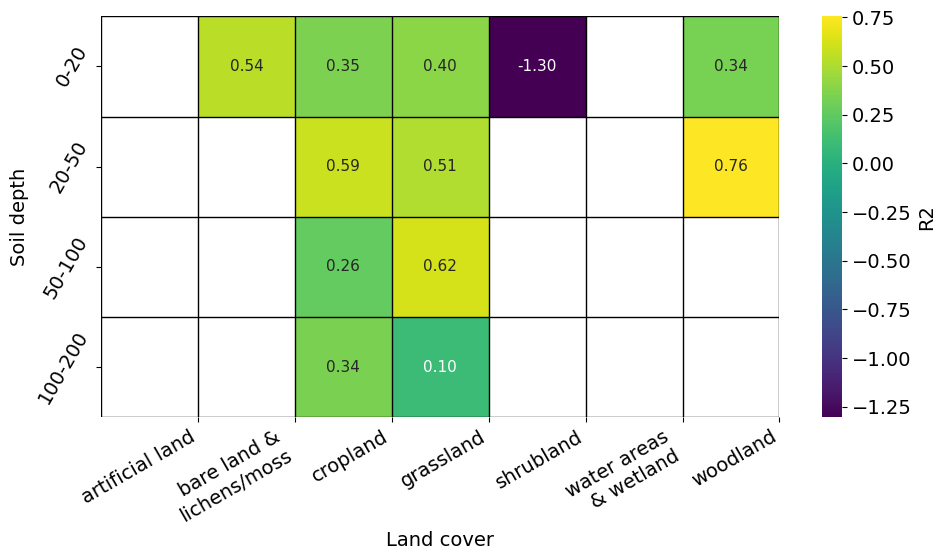

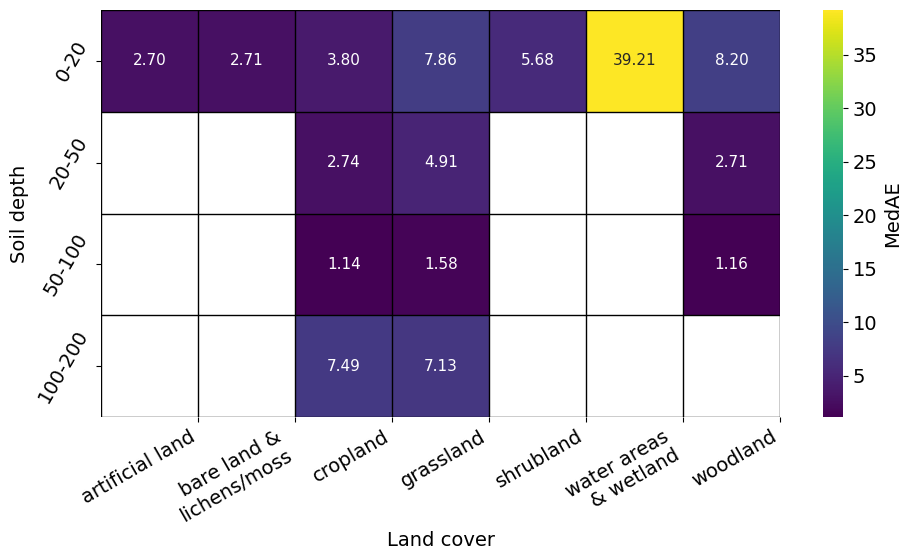

In [20]:
# Loop through the other metrics and plot separately
metrics_to_plot = ['MAE', 'R2', 'MedAE']  # Choose metrics to represent

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))

    # Pivot data for heatmap
    pivot_data = lc_dep_df.pivot(index='hzn_dep_bin', columns='lc_survey', values=metric)

    # Reorder the index (soil depth) to match the desired order
    pivot_data = pivot_data.reindex(soil_depth_order)

    # Plot heatmap
    ax = sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        cbar_kws={'label': metric},
        annot_kws={"fontsize": 11},  # Smaller font size for annotations
    )

    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)  # Font size for colorbar ticks
    cbar.set_label(metric, size=14)  # Font size for colorbar label

    # Add explicit grid lines
    for i in range(pivot_data.shape[0] + 1):  # Horizontal grid lines
        ax.axhline(i, color='black', linewidth=1)
    for j in range(pivot_data.shape[1] + 1):  # Vertical grid lines
        ax.axvline(j, color='black', linewidth=1)

    # Titles and labels
    # ax.set_title(metric, fontsize=14)
    ax.set_xlabel('Land cover', fontsize=14)
    ax.set_ylabel('Soil depth', fontsize=14)

    # Move x-ticks and y-ticks to the center of each bin
    ax.set_xticks(np.arange(len(pivot_data.columns)) + 1)
    ax.set_xticklabels(pivot_data.columns, rotation=30, ha='right', fontsize=14)

    # ax.set_yticks(np.arange(len(pivot_data.index)) + 0.5)
    ax.set_yticklabels(pivot_data.index, rotation=60, fontsize=14)

    plt.tight_layout()
    plt.show()

## Plot metrics by time

In [21]:
# Filter for rows with non-NaN `lc_survey`
time_df = stratified_results_df.loc[stratified_results_df['time'].notna()]

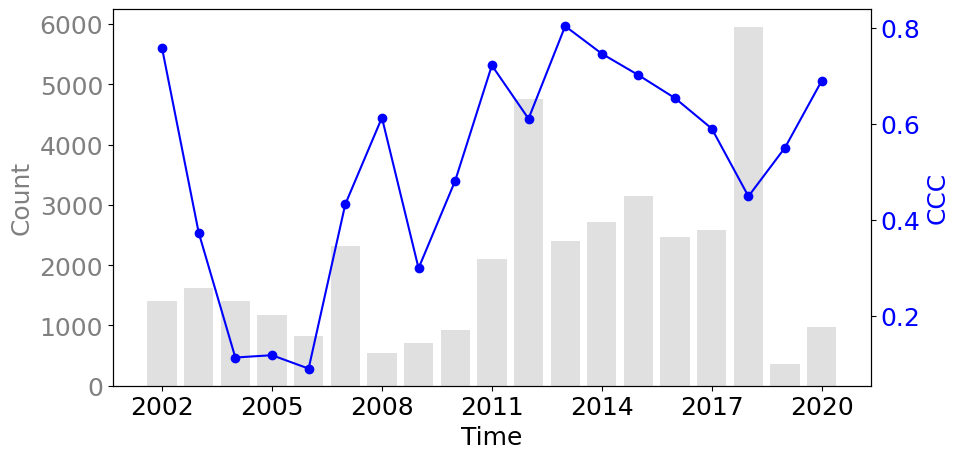

In [22]:
import matplotlib.pyplot as plt

# Sort the DataFrame by time
time_df = time_df.sort_values(by='time')

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the bar plot for 'count'
ax1.bar(time_df['time'], time_df['train count'], color='lightgray', alpha=0.7, label='Count')
ax1.set_xlabel('Time', fontsize=18)
ax1.set_ylabel('Count', fontsize=18, color='gray')
ax1.tick_params(axis='y', labelcolor='gray',labelsize=18)

# Set custom ticks for the x-axis
custom_ticks = [2002, 2005, 2008, 2011, 2014, 2017, 2020]
ax1.set_xticks(custom_ticks)
ax1.set_xticklabels(custom_ticks, fontsize=18)


# Create a second y-axis for 'CCC' and 'MedAE'
ax2 = ax1.twinx()

# Plot 'CCC' as a line
ax2.plot(time_df['time'], time_df['CCC'], color='blue', marker='o', label='CCC')
ax2.set_ylabel('CCC', fontsize=18, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=18)

# # Plot 'MedAE' as a line
# ax2.plot(time_df['time'], time_df['MedAE'], color='green', marker='s', linestyle='--', label='MedAE')

# Add a legend
lines, labels = [], []
for ax in [ax1, ax2]:
    ax_lines, ax_labels = ax.get_legend_handles_labels()
    lines.extend(ax_lines)
    labels.extend(ax_labels)
    
# # ax2.legend(lines, labels, loc='upper right', fontsize=12)
# ax2.legend(lines, labels, bbox_to_anchor=(0.3, 1), fontsize=12)


# Show the plot
plt.tight_layout()
plt.savefig(f'{folder_path}/figure/figure_metrics_time_v{version}.pdf', bbox_inches='tight')
plt.show()


In [23]:
t2015 = test.loc[test['time']==2009]
t2015.groupby(['lc_survey', 'hzn_dep_bin']).size().unstack(fill_value=0)

hzn_dep_bin,0-20,20-50,50-100,100-200
lc_survey,,,,
cropland,15,2,1,0
grassland,12,0,0,0
woodland,13,0,0,0


In [24]:
for ii in range(2002,2021):
    tt = test.loc[test['time']==ii]
    print(ii)
    print('lc', len(tt['lc_survey'].unique()), tt['lc_survey'].unique().tolist())
    print('depth', len(tt['hzn_dep_bin'].unique()), tt['hzn_dep_bin'].unique().tolist())
    print()

2002
lc 3 ['woodland', 'grassland', 'cropland']
depth 1 ['0-20']

2003
lc 3 ['grassland', 'cropland', 'woodland']
depth 1 ['0-20']

2004
lc 4 ['woodland', 'grassland', None, 'cropland']
depth 4 ['0-20', '20-50', '100-200', '50-100']

2005
lc 3 ['grassland', 'woodland', 'cropland']
depth 1 ['0-20']

2006
lc 3 ['grassland', 'woodland', 'cropland']
depth 1 ['0-20']

2007
lc 4 ['grassland', 'woodland', 'cropland', None]
depth 3 ['0-20', '50-100', '20-50']

2008
lc 3 ['woodland', 'cropland', 'grassland']
depth 3 ['0-20', '20-50', '50-100']

2009
lc 3 ['grassland', 'cropland', 'woodland']
depth 3 ['0-20', '50-100', '20-50']

2010
lc 3 ['cropland', 'grassland', 'woodland']
depth 1 ['0-20']

2011
lc 2 ['grassland', 'cropland']
depth 4 ['50-100', '0-20', '20-50', '100-200']

2012
lc 4 ['cropland', 'woodland', 'grassland', None]
depth 4 ['0-20', '50-100', '20-50', '100-200']

2013
lc 2 ['grassland', 'cropland']
depth 4 ['50-100', '20-50', '0-20', '100-200']

2014
lc 3 ['cropland', 'woodland', 'g